# **Roberta Sentinel Model Building**

### This notebook contains the code for building the Roberta Sentinel model. The model is trained on the ChatGPT and OpenWeb datasets. The model is then evaluated on the test set and the metrics are calculated. The model is then saved to a file.

# 0. Read the Original Dataset


### 0.1 The original dataset is read from the jsonl files and converted to a pandas dataframe. We then label the ChatGPT data as 1 and OpenWeb as 0, and combine them together to become one dataframe.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

ChatGPT = []
OpenWeb = []

# Read all the jsonl files in the path
for i in range(8):
    a = pd.read_json(f"dataset/chatgpt/urlsf_subset0{i}.jsonl", lines=True)
    b = pd.read_json(f"dataset/openweb/urlsf_subset0{i}.jsonl", lines=True)
    ChatGPT.append(a)
    OpenWeb.append(b)

# Combine dataframes of the same type
chatgpt_df = pd.concat(ChatGPT, ignore_index=True)
openweb_df = pd.concat(OpenWeb, ignore_index=True)

# Assign labels
chatgpt_df['label'] = 1
openweb_df['label'] = 0

# Combine both labeled dataframes
combined_df = pd.concat([chatgpt_df, openweb_df], ignore_index=True)
combined_df.head()

,uid,text,label
0,[urlsf_subset00]-[83],The National Weather Service's Mike McFarland ...,1
1,[urlsf_subset00]-[89],The President of the United States was seen on...,1
2,[urlsf_subset00]-[390],Enner Valencia scored two goals in Ecuador's 2...,1
3,[urlsf_subset00]-[457],"Beginning with the introduction, the author sh...",1
4,[urlsf_subset00]-[458],Mexico has implemented its newest data retenti...,1


In [3]:
print(combined_df.shape)
combined_df['label'].value_counts()

(58537, 3)


1    29395
0    29142
Name: label, dtype: int64

### 0.2 In this section, we preprocess the Dataset. We extract the hidden states from all of the text by using Roberta Model. We then have the X and y values for the model.

In [4]:
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaModel
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Initialize the tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaModel.from_pretrained("roberta-base").to('cuda')

def extract_features(text):
    tokenized_text = tokenizer.encode(text, truncation=True, max_length=512, return_tensors="pt").to('cuda')
    outputs = model(tokenized_text)
    last_hidden_states = outputs.last_hidden_state
    TClassification = last_hidden_states[:, 0, :].squeeze().detach().cpu().numpy()
    return TClassification

# Assuming you have a dataframe combined_df with a 'text' column and a 'label' column
features = combined_df['text'].apply(extract_features)
labels = combined_df['label'].tolist()

# Convert extracted features to a format suitable for PyTorch
X = np.array(features.tolist())
y = np.array(labels)
X, y

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(array([[-5.11931144e-02,  1.16266675e-01,  2.12036110e-02, ...,
         -5.63658886e-02, -3.32730711e-02,  5.68893878e-03],
        [-6.35785013e-02,  7.72023574e-02,  1.69519372e-02, ...,
         -9.07599479e-02, -1.45020848e-02, -2.63511632e-02],
        [-4.60926928e-02,  1.01213977e-01,  2.46110968e-02, ...,
         -4.41155061e-02,  6.20419669e-05, -3.49129736e-02],
        ...,
        [-7.53861666e-02,  8.98229852e-02,  2.71067135e-02, ...,
         -9.96468365e-02, -6.26214370e-02,  1.13755856e-02],
        [-7.61107877e-02,  8.66875350e-02,  1.53271351e-02, ...,
         -5.03607690e-02, -5.49129630e-03, -7.77193252e-03],
        [-8.64653289e-02,  6.55829459e-02,  2.51406208e-02, ...,
         -3.54760848e-02, -3.68417650e-02, -2.72565763e-02]], dtype=float32),
 array([1, 1, 1, ..., 0, 0, 0]))

### 0.3 The Preprocessed Dataset is saved to a csv file for usages later.

In [5]:
combined_df['extracted_features'] = features
combined_df['label'] = labels

# Save the DataFrame to CSV
combined_df.to_csv('Combined-Preprocessed-Dataset.csv', index=False)

# 1. Train, Validation, and Test Split

### 1.1 The preprocessed dataset is read from the csv file. The extracted features are converted from string representation of lists into actual lists of numbers. The lists of numbers are then converted into numpy arrays. The labels are also converted into numpy arrays.

In [6]:
import pandas as pd
import numpy as np
# Load the data
combined_df = pd.read_csv('dataset/Combined-Preprocessed-Dataset.csv')

# Convert the string representation of lists into actual lists of numbers
X = combined_df['extracted_features'].str.replace('\n', '').str.strip('[]').str.split().apply(lambda x: [float(i) for i in x])

# Convert lists of numbers into numpy arrays
X = np.array(X.tolist())

# Get the labels as a numpy array
y = np.array(combined_df['label'].tolist())

X, y

(array([[-5.11931144e-02,  1.16266675e-01,  2.12036110e-02, ...,
         -5.63658886e-02, -3.32730711e-02,  5.68893878e-03],
        [-6.35785013e-02,  7.72023574e-02,  1.69519372e-02, ...,
         -9.07599479e-02, -1.45020848e-02, -2.63511632e-02],
        [-4.60926928e-02,  1.01213977e-01,  2.46110968e-02, ...,
         -4.41155061e-02,  6.20419669e-05, -3.49129736e-02],
        ...,
        [-7.53861666e-02,  8.98229852e-02,  2.71067135e-02, ...,
         -9.96468365e-02, -6.26214370e-02,  1.13755856e-02],
        [-7.61107877e-02,  8.66875350e-02,  1.53271351e-02, ...,
         -5.03607690e-02, -5.49129630e-03, -7.77193252e-03],
        [-8.64653289e-02,  6.55829459e-02,  2.51406208e-02, ...,
         -3.54760848e-02, -3.68417650e-02, -2.72565763e-02]]),
 array([1, 1, 1, ..., 0, 0, 0]))

### 1.2 The data is split into train, validation, and test sets. The train set is 80% of the data, the validation set is 10% of the data, and the test set is 10% of the data. Validation set is used to tune the hyperparameters of the model. The test set is used to evaluate the model.

In [7]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset

# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

# 2. Model Building

### 2.1 The model is defined as a simple MLP model with 2 hidden layers. The model is trained on the train set and validated on the validation set. The model is trained for 15 epochs with a batch size of 512.

In [8]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Define a simple MLP model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 2)
        self.gelu = nn.GELU()

    def forward(self, x):
        intermediate = self.gelu(self.fc1(x))
        output = self.fc2(intermediate)
        return output


mlp_model = MLP(X_train.shape[1]).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(mlp_model.parameters(), lr=1e-4, weight_decay=1e-3)

### 2.2 The model is trained for 15 epochs with a batch size of 512. The training loss and validation loss are plotted to see if the model is overfitting or not.

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, det_curve

# Train the model
epochs = 15
batch_size = 512

# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_precisions = []
val_precisions = []
train_f1s = []
val_f1s = []

for epoch in range(epochs):
    mlp_model.train()
    running_loss = 0.0
    all_train_predictions = []
    all_train_labels = []

    for inputs, labels in DataLoader(train_dataset, batch_size=batch_size, shuffle=True):
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        optimizer.zero_grad()
        outputs = mlp_model(inputs.float())
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        all_train_predictions.extend(predicted.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

    train_losses.append(running_loss/len(train_dataset))

    train_accuracy = np.mean(np.array(all_train_predictions) == np.array(all_train_labels))
    train_precision = precision_score(all_train_labels, all_train_predictions)
    train_f1 = f1_score(all_train_labels, all_train_predictions)

    train_accuracies.append(train_accuracy)
    train_precisions.append(train_precision)
    train_f1s.append(train_f1)

    # Validation logic
    mlp_model.eval()
    val_loss = 0.0
    all_val_predictions = []
    all_val_labels = []

    with torch.no_grad():
        for inputs, labels in DataLoader(val_dataset, batch_size=batch_size):
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = mlp_model(inputs.float())
            _, predicted = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            all_val_predictions.extend(predicted.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    val_losses.append(val_loss/len(val_dataset))

    val_accuracy = np.mean(np.array(all_val_predictions) == np.array(all_val_labels))
    val_precision = precision_score(all_val_labels, all_val_predictions)
    val_f1 = f1_score(all_val_labels, all_val_predictions)

    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train F1: {train_f1:.4f}")
    print(f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}, Val Precision: {val_precision:.4f}, Val F1: {val_f1:.4f}")
    print('-----------------------------------')

Epoch 1/15
Train Loss: 0.0013, Train Accuracy: 0.7038, Train Precision: 0.6775, Train F1: 0.7281
Val Loss: 0.0013, Val Accuracy: 0.8732, Val Precision: 0.8730, Val F1: 0.8730
-----------------------------------
Epoch 2/15
Train Loss: 0.0012, Train Accuracy: 0.8693, Train Precision: 0.8287, Train F1: 0.8780
Val Loss: 0.0011, Val Accuracy: 0.8879, Val Precision: 0.8501, Val F1: 0.8935
-----------------------------------
Epoch 3/15
Train Loss: 0.0010, Train Accuracy: 0.8923, Train Precision: 0.8583, Train F1: 0.8981
Val Loss: 0.0009, Val Accuracy: 0.8912, Val Precision: 0.8446, Val F1: 0.8979
-----------------------------------
Epoch 4/15
Train Loss: 0.0007, Train Accuracy: 0.9051, Train Precision: 0.8813, Train F1: 0.9088
Val Loss: 0.0007, Val Accuracy: 0.9103, Val Precision: 0.8860, Val F1: 0.9129
-----------------------------------
Epoch 5/15
Train Loss: 0.0006, Train Accuracy: 0.9145, Train Precision: 0.8982, Train F1: 0.9169
Val Loss: 0.0006, Val Accuracy: 0.9172, Val Precision: 0.91

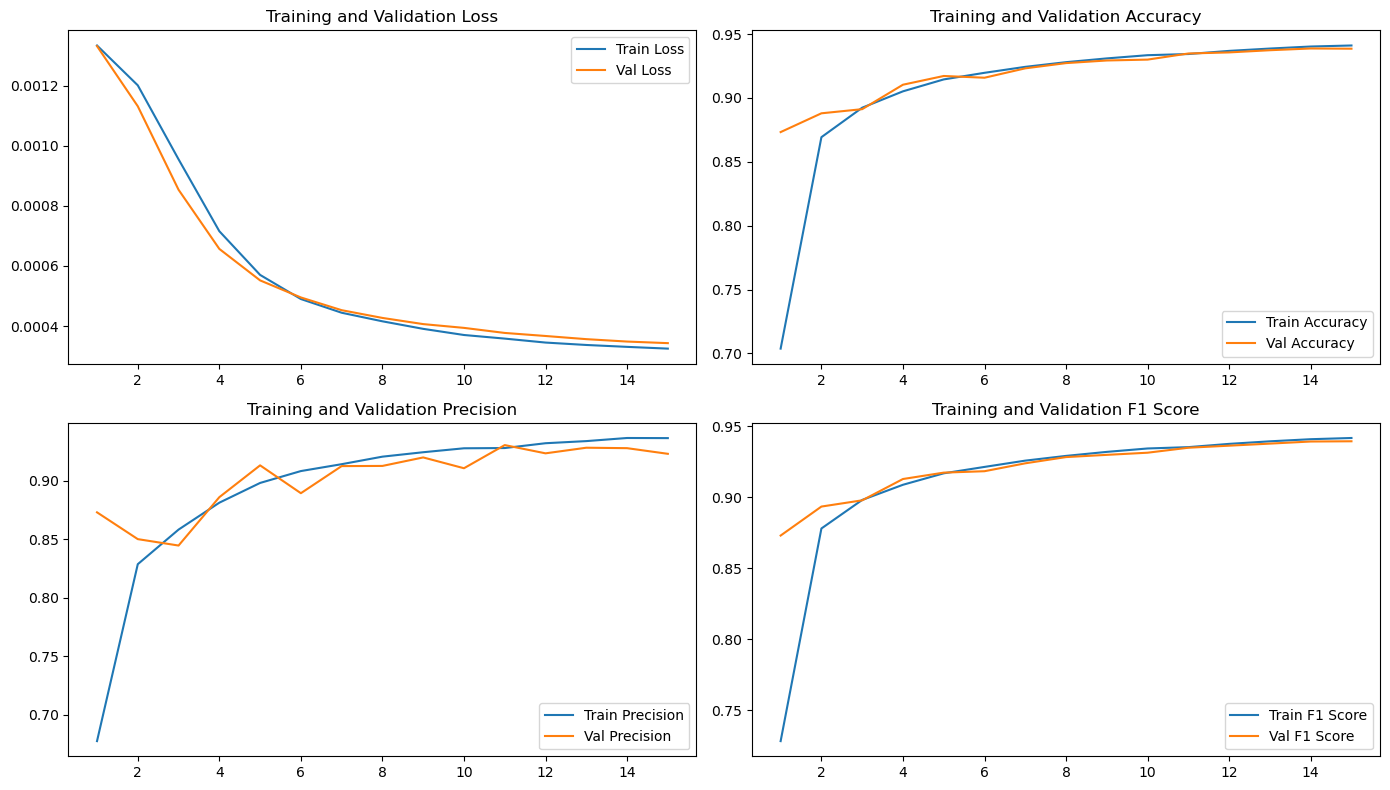

In [10]:
import matplotlib.pyplot as plt

# Plot metrics
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 3)
plt.plot(epochs_range, train_precisions, label='Train Precision')
plt.plot(epochs_range, val_precisions, label='Val Precision')
plt.legend(loc='lower right')
plt.title('Training and Validation Precision')

plt.subplot(2, 2, 4)
plt.plot(epochs_range, train_f1s, label='Train F1 Score')
plt.plot(epochs_range, val_f1s, label='Val F1 Score')
plt.legend(loc='lower right')
plt.title('Training and Validation F1 Score')

plt.tight_layout()
plt.show()

### The model does not seems to be a bit overfitting. There is no significant sign of accuracy, precision, and F1 score decreasing or loss increasing. The model is trained for 15 epochs, but it seems that the model is not overfitting yet. The model can be trained for more epochs to see if the model is overfitting or not.

# 3. Model Evaluation

### 3.1 The model is evaluated on the test set. The accuracy, precision, recall, and F1 score are calculated.

outputs tensor([[-2.1358,  2.7432],
        [-0.7984,  1.3495],
        [-0.8369,  1.3822],
        ...,
        [ 0.4756,  0.0511],
        [-1.9841,  2.5621],
        [-1.9724,  2.5755]], device='cuda:0')
Accuracy: 0.934
Precision: 0.921
Recall: 0.950
F1 Score: 0.935
False Positive Rate: 0.05049811061490896
False Negative Rate: 0.08069996602106694


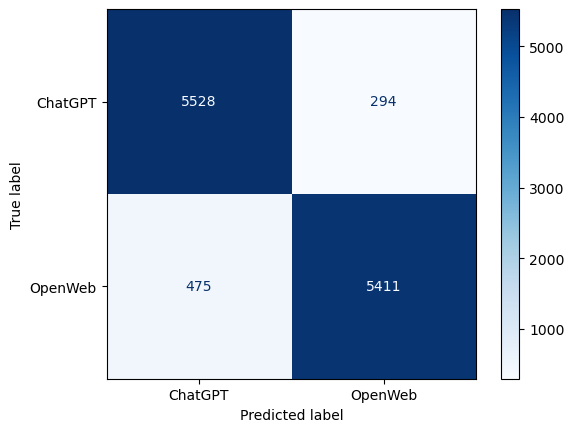

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, det_curve, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import torch.nn.functional as F
# Evaluate the model and calculate metrics
mlp_model.eval()
all_labels = []
all_predictions = []
all_probabilities = []
i = 1

with torch.no_grad():
    for inputs, labels in DataLoader(test_dataset, batch_size=batch_size):
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = mlp_model(inputs.float())
        if i == 1:
            print("outputs", outputs)
            i += 1
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probabilities.extend(F.softmax(outputs, dim=1)[:, 1].cpu().numpy())  # Get probabilities for class 1

CM = confusion_matrix(all_labels, all_predictions)
# Make ChatGPT as positive class
CM = np.array([[CM[1][1], CM[1][0]], [CM[0][1], CM[0][0]]])
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
FPR = CM[0][1] / (CM[0][1] + CM[0][0])
FNR = CM[1][0] / (CM[1][0] + CM[1][1])

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"False Positive Rate: {FPR}")
print(f"False Negative Rate: {FNR}")


# Plot CM and show data labels
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=['ChatGPT', 'OpenWeb'])
disp.plot(cmap='Blues', values_format='d')

### 3.2 The ROC curve and AUC are calculated and plotted. It seems that the model is performing extremely well.

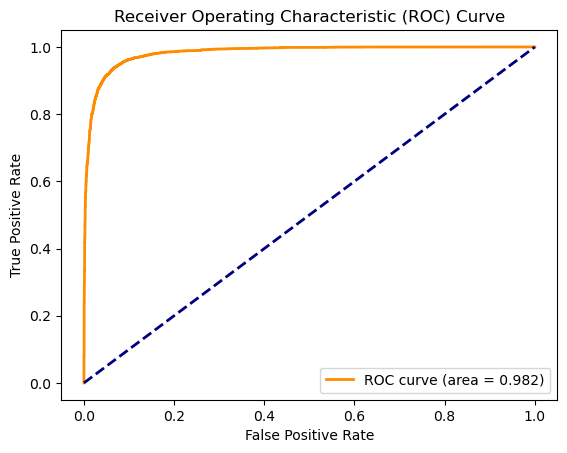

In [12]:
from sklearn.metrics import roc_curve, auc
# ROC Curve and AUC
fpr, tpr, _ = roc_curve(all_labels, all_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


### 3.3 The DET curve is calculated and plotted. It also seems to indicate that the model is performing extremely well, since the curve is very close to the ideal curve.

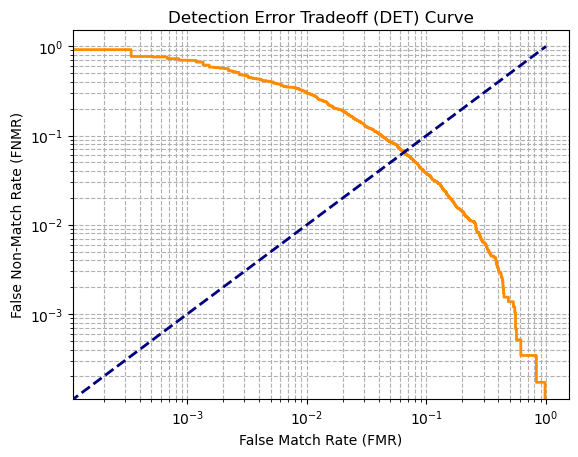

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(all_labels, all_probabilities)

# Compute False Match Rate and False Non-Match Rate
fmr = fpr
fnmr = 1 - tpr

# Plot the DET curve
plt.figure()
plt.plot(fmr, fnmr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('False Match Rate (FMR)')
plt.ylabel('False Non-Match Rate (FNMR)')
plt.title('Detection Error Tradeoff (DET) Curve')
plt.grid(True, which="both", ls="--")
plt.show()


### 3.4 Save the model to a file for future usages.

In [14]:
# Save Model
torch.save(mlp_model.state_dict(), 'RobertaSentinel.pth')

# 4. Conclusion

### The Roberta Sentinel model is trained on the ChatGPT and OpenWeb datasets. The model is then evaluated on the test set and the metrics are calculated along side with the ROC curve and DET curve. So far, all of the results follows the GPT-Sentinel Report. The model seems to be performing extremely well, and the evaluation metrics indicate that the model is performing well. In addition, There is no obvious sign of overfitting as well.
### However, this model should be tested on more datasets to see if the model is actually performing well or not.